In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from numpy import absolute, mean, std
from sklearn import preprocessing, metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, validation_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder;
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
def readCSVFiles():

    df01 = pd.read_csv("bellman_performance_results.csv")
    df02 = pd.read_csv("dijkstra_performance_results.csv")
    df03 = pd.read_csv("hybrid_performance_results.csv")

    return df01, df02, df03

def combineAlgorithmsToFile(df01, df02, df03):
    df01['AlgoBellman'] = 1
    df01['AlgoDijkstra'] = 0
    df01['AlgoHybrid'] = 0
    df02['AlgoBellman'] = 0
    df02['AlgoDijkstra'] = 1
    df02['AlgoHybrid'] = 0
    df03['AlgoBellman'] = 0
    df03['AlgoDijkstra'] = 0
    df03['AlgoHybrid'] = 1
    #frames = [df01, df02, df03]
    #concat = pd.append(frames)
    df04 = df01.append(df02,ignore_index=True)
    df05 = df04.append(df03,ignore_index=True)
    df1 = df05
    
    return df1

def combineAlgorithmsToFilev2(df01):
    df01['AlgoBellman'] = 1
    df01['AlgoDijkstra'] = 0
    df01['AlgoHybrid'] = 0
    
    
    
    return df01

beta = 0.0000000001
def executionTimeToSpeedup(df):
    
    algorithms = ['AlgoBellman', 'AlgoDijkstra', 'AlgoHybrid']
    vertexNums = [524288, 1048576, 2097152, 4194304, 8388608, 16777216]
    df['speedup'] = 1.0

    for al in algorithms:
        for v in vertexNums:
            base = df.loc[(df[al] == 1) & (df['vertexNum'] == v) & (df['sOriginalDistance'] == 1), 'executionTime']
            df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'speedup'] = base.values/((df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'executionTime']).astype(float))

    #print(df['speedup'])
    df['Error'] = df['Error'] + beta
    return df
    
def executionTimeToSpeedupv2(df):
    
    vertexNums = [524288, 1048576, 2097152, 4194304, 8388608, 16777216, 264346, 321270, 435666, 1070376, 1207945, 1524453, 1890815, 2758119, 3598623, 6262104, 14081816, 23947347]
    df['speedup'] = 1.0

    for v in vertexNums:
      base = df.loc[(df['vertexNum'] == v) & (df['sOriginalDistance'] == 1), 'executionTime']
      df.loc[(df['vertexNum'] == v), 'speedup'] = base.values/((df.loc[(df['vertexNum'] == v), 'executionTime']).astype(float))

    #print(df['speedup'])
    df['Error'] = df['Error'] + beta
    return df

def preprocessing(df1):
    conditions = [df1['vertexNum'] == 524288, df1['vertexNum'] == 1048576, df1['vertexNum'] == 2097152, df1['vertexNum'] == 4194304, df1['vertexNum'] == 8388608, df1['vertexNum'] == 16777216]
    numbers = [1, 2, 4, 8, 16, 32]
    df1['graphSize'] = np.select(conditions, numbers, default=0)
    
    df1 = df1.drop(['vertexNum', 'edgeNum', 'maxEdgeDegree',
                    'sAtomicBlock', 'executionTime'], axis=1)
    df1.dropna(inplace=True)
    
    df1 = df1[df1['minProcessEdge'] >= 0]
              
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['minProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['minProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['minProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['minProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    df1 = df1[df1['maxProcessEdge'] >= 0]
              
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['maxProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['maxProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    df1['Error'] = df1['Error']/100
    
    return df1

def replaceIterations(df1):
    newiter = [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    
    condition = [df1['iterationNum'] == 128, df1['iterationNum'] == 127, df1['iterationNum'] == 115, df1['iterationNum'] == 103, df1['iterationNum'] == 91, df1['iterationNum'] == 79, df1['iterationNum'] == 67, df1['iterationNum'] == 55, df1['iterationNum'] == 43, df1['iterationNum'] == 31, df1['iterationNum'] == 19]
    df1['iterationNum'] = np.select(condition, newiter)

    #df1.loc[df1['vertexNum'] == 264346, ['iterationNum']] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 126, df1['iterationNum'] == 125, df1['iterationNum'] == 113, df1['iterationNum'] == 101, df1['iterationNum'] == 89, df1['iterationNum'] == 77, df1['iterationNum'] == 65, df1['iterationNum'] == 53, df1['iterationNum'] == 41, df1['iterationNum'] == 29, df1['iterationNum'] == 17]
    df1['iterationNum'] = np.select(condition, newiter)
  
    condition = [df1['iterationNum'] == 204, df1['iterationNum'] == 203, df1['iterationNum'] == 183, df1['iterationNum'] == 163, df1['iterationNum'] == 143, df1['iterationNum'] == 123, df1['iterationNum'] == 103, df1['iterationNum'] == 83, df1['iterationNum'] == 63, df1['iterationNum'] == 43, df1['iterationNum'] == 23]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 210, df1['iterationNum'] == 209, df1['iterationNum'] == 188, df1['iterationNum'] == 167, df1['iterationNum'] == 146, df1['iterationNum'] == 125, df1['iterationNum'] == 104, df1['iterationNum'] == 83, df1['iterationNum'] == 62, df1['iterationNum'] == 41, df1['iterationNum'] == 20]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 288, df1['iterationNum'] == 287, df1['iterationNum'] == 259, df1['iterationNum'] == 231, df1['iterationNum'] == 203, df1['iterationNum'] == 175, df1['iterationNum'] == 147, df1['iterationNum'] == 119, df1['iterationNum'] == 91, df1['iterationNum'] == 63, df1['iterationNum'] == 35]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 208, df1['iterationNum'] == 207, df1['iterationNum'] == 187, df1['iterationNum'] == 167, df1['iterationNum'] == 147, df1['iterationNum'] == 127, df1['iterationNum'] == 107, df1['iterationNum'] == 87, df1['iterationNum'] == 67, df1['iterationNum'] == 47, df1['iterationNum'] == 27]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 245, df1['iterationNum'] == 244, df1['iterationNum'] == 220, df1['iterationNum'] == 196, df1['iterationNum'] == 172, df1['iterationNum'] == 148, df1['iterationNum'] == 124, df1['iterationNum'] == 100, df1['iterationNum'] == 76, df1['iterationNum'] == 52, df1['iterationNum'] == 28]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 292, df1['iterationNum'] == 291, df1['iterationNum'] == 262, df1['iterationNum'] == 233, df1['iterationNum'] == 204, df1['iterationNum'] == 175, df1['iterationNum'] == 146, df1['iterationNum'] == 117, df1['iterationNum'] == 88, df1['iterationNum'] == 59, df1['iterationNum'] == 30]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 277, df1['iterationNum'] == 276, df1['iterationNum'] == 249, df1['iterationNum'] == 222, df1['iterationNum'] == 195, df1['iterationNum'] == 168, df1['iterationNum'] == 141, df1['iterationNum'] == 114, df1['iterationNum'] == 87, df1['iterationNum'] == 60, df1['iterationNum'] == 33]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 583, df1['iterationNum'] == 582, df1['iterationNum'] == 524, df1['iterationNum'] == 466, df1['iterationNum'] == 408, df1['iterationNum'] == 350, df1['iterationNum'] == 292, df1['iterationNum'] == 234, df1['iterationNum'] == 176, df1['iterationNum'] == 118, df1['iterationNum'] == 60]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 422, df1['iterationNum'] == 421, df1['iterationNum'] == 379, df1['iterationNum'] == 337, df1['iterationNum'] == 295, df1['iterationNum'] == 253, df1['iterationNum'] == 211, df1['iterationNum'] == 169, df1['iterationNum'] == 127, df1['iterationNum'] == 85, df1['iterationNum'] == 43]
    df1['iterationNum'] = np.select(condition, newiter)

    condition = [df1['iterationNum'] == 561, df1['iterationNum'] == 560, df1['iterationNum'] == 504, df1['iterationNum'] == 448, df1['iterationNum'] == 392, df1['iterationNum'] == 336, df1['iterationNum'] == 280, df1['iterationNum'] == 224, df1['iterationNum'] == 168, df1['iterationNum'] == 112, df1['iterationNum'] == 56]
    df1['iterationNum'] = np.select(condition, newiter)
    return df1

def preprocessing_v2(df1):
    conditions = [df1['vertexNum'] == 524288, df1['vertexNum'] == 1048576, df1['vertexNum'] == 2097152, df1['vertexNum'] == 4194304, df1['vertexNum'] == 8388608, df1['vertexNum'] == 16777216, df1['vertexNum'] == 321270, df1['vertexNum'] == 1890815, df1['vertexNum'] == 435666, df1['vertexNum'] == 3598623, df1['vertexNum'] == 1070376, df1['vertexNum'] == 2758119, df1['vertexNum'] == 1524453, df1['vertexNum'] == 1207945, df1['vertexNum'] == 264346, df1['vertexNum'] == 23947347, df1['vertexNum'] == 6262104, df1['vertexNum'] == 14081816]
    
    numbers = [1, 2, 4, 8, 16, 32, 1, 4, 1, 8, 2, 4, 2, 2, 1, 32, 8, 16]
    df1['graphSize'] = np.select(conditions, numbers, default=0)
    
    df1 = df1.drop(['vertexNum', 'edgeNum', 'maxEdgeDegree',
                    'sAtomicBlock', 'executionTime'], axis=1)
    df1.dropna(inplace=True)
    
    df1 = df1[df1['minProcessEdge'] >= 0]
    df1 = df1[df1['minProcessEdge'] < 1000]
        
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['minProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['minProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['minProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['minProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    df1 = df1[df1['maxProcessEdge'] >= 0]
    df1 = df1[df1['maxProcessEdge'] < 1000]
              
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['maxProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['maxProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    
    #iterations = [df1['iterationNum'] ==  721, df1['iterationNum'] == 720, df1['iterationNum'] ==  648, df1['iterationNum'] ==  576, df1['iterationNum'] ==  504, df1['iterationNum'] ==  432, df1['iterationNum'] ==  360, df1['iterationNum'] ==  288, df1['iterationNum'] ==  216, df1['iterationNum'] ==  144, df1['iterationNum'] ==  72]


    df1['Error'] = df1['Error']/100
    
    return df1

def _regressorAlgorithm(model, x_train, x_test, y_train, y_test):
    #fit to model
    model.fit(x_train, y_train)
    #predict the outcome
    y_pred = model.predict(x_test)
    #summarize performance
    print("\n### Performance Summarization of _regressorAlgorithm ###\n")
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 score: ', r2_score(y_test, y_pred))
    print('Explained Variance Score: ', explained_variance_score(y_test, y_pred))
    print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(y_test, y_pred))
    #print('MAPE: ', MAPE(y_test, y_pred))
    
    return y_pred, y_test

def _regressorAlgorithm_KFold(model, X, y):
    #model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    # evaluate the model and collect the scores
    n_scores_mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    n_scores_rmse = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    n_scores_r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    n_scores_ev = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1)
    n_scores_mape = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    # force the scores to be positive
    n_scores_mae = absolute(n_scores_mae)
    n_scores_mse = absolute(n_scores_mse)
    n_scores_rmse = absolute(n_scores_rmse)
    n_scores_r2 = absolute(n_scores_r2)
    n_scores_ev = absolute(n_scores_ev)
    n_scores_mape = absolute(n_scores_mape)
    # summarize performance
    print("\n### Performance Summarization of _regressorAlgorithm_KFold ###\n")
    print('Mean Absolute Error (avg): %.5f' % mean(n_scores_mae))
    print('Mean Squared Error (avg): %.5f' % mean(n_scores_mse))
    print('Root Mean Squared Error (avg): %.5f' % mean(n_scores_rmse))
    print('R2 score (avg) %.5f' % mean(n_scores_r2))
    print('Explained Variance (avg): %.5f' % mean(n_scores_ev))
    print('Mean Absolute Percentage Error (avg): %.5f' % mean(n_scores_mape))
    
def draw_BFDJ(arr1_b, arr2_b, arr1_d, arr2_d, x_label, y_label):
    
    asterisk = mpath.Path.unit_regular_asterisk(6)
    circle = mpath.Path.unit_circle()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(arr1_b, arr2_b, color='red', label='predicted_data', marker=asterisk, markersize=7)
    ax.plot(arr1_d, arr2_d, color='blue', label='test_data', marker=circle, markersize=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.legend()
    plt.show()
    
def lineGraphOfPredictionError(y_test, y_pred):
    y_pred_exec, y_pred_err, y_test_exec, y_test_err = [], [], [], []
    y_test_n = y_test.to_numpy()
    y_pred_n = y_pred
    y_test_n.sort()
    y_pred_n.sort()
    for i in range(20):
        y_pred_exec.append(y_pred_n[i][1])
        y_pred_err.append(y_pred_n[i][0])
        y_test_exec.append(y_test_n[i][1])
        y_test_err.append(y_test_n[i][0])

    y_pred_exec.sort()
    y_test_exec.sort()
    y_pred_err.sort()
    y_test_err.sort()
    print(y_pred_exec)
    print(y_test_exec)


    draw_BFDJ(y_pred_exec, y_pred_err, y_test_exec, y_test_err, "execution time", "error")
    
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print(y_true.shape)
    print(y_pred.shape)
    acc_ex, acc_err = 0, 0
    
    for i in range(len(y_true)):
        if y_true[i][0] != 0:
            acc_ex += np.abs((y_true[i][0] - y_pred[i][0]) / y_true[i][0])
        elif y_true[i][0] == 0 and y_pred[i][0] != 0:
            acc_ex += np.abs((y_true[i][0] - y_pred[i][0]) / y_pred[i][0])
        #print(acc_ex)
        
    mean_ex = (acc_ex / len(y_true)) * 100
    
    for i in range(len(y_true)):
        if y_true[i][1] != 0:
            acc_err += np.abs((y_true[i][1] - y_pred[i][1]) / y_true[i][1])
        elif y_true[i][1] == 0 and y_pred[i][1] != 0:
            acc_err += np.abs((y_true[i][1] - y_pred[i][1]) / y_pred[i][1])
        
        #print(acc_err)
        
    mean_err = (acc_err / len(y_true)) * 100
    
    return (mean_ex + mean_err)/2
    

In [ ]:
'''
y_pred_knr=np.array(y_pred_knr)
y_test_knr=np.array(y_test_knr)
print(y_pred_knr[1][1])
print(y_test_knr[1][1])
'''

'\ny_pred_knr=np.array(y_pred_knr)\ny_test_knr=np.array(y_test_knr)\nprint(y_pred_knr[1][1])\nprint(y_test_knr[1][1])\n'

In [ ]:
#df01, df02, df03 = readCSVFiles()
#df1 = combineAlgorithmsToFile(df01, df02, df03)
#df2 = executionTimeToSpeedup(df1)
#df1 = preprocessing(df2)
#df1['config'] = df1['iterationNum'] * 5 * 7 * df1[]
#df1.shape

(39719, 15)

In [4]:
df1 = pd.read_csv("bellman_performance_results.csv")
df1 = combineAlgorithmsToFilev2(df1)
df2 = executionTimeToSpeedupv2(df1)
df1 = preprocessing(df2)
df1.shape

(12599, 15)

In [5]:
df1R = pd.read_csv("bellman_performance_results_real.csv")
df1R = combineAlgorithmsToFilev2(df1R)
#df1R.drop(df1R[df1R['vertexNum'] == 23947347].index, inplace = True)
#df1R.drop(df1R[df1R['vertexNum'] == 14081816].index, inplace = True)
#df1R.drop(df1R[df1R['vertexNum'] == 6262104].index, inplace = True)

df2R = executionTimeToSpeedupv2(df1R)
#df1R.drop(df1R[df1R['speedup'] >120].index, inplace = True)
df1R = replaceIterations(df1R)
df1R = preprocessing_v2(df2R)
df1R.shape
display(df1R)

,iterationNum,minProcessEdge,maxProcessEdge,percentage,sOriginalDistance,sMinEdgetoProcess,sMaxEdgetoProcess,sPartialGraphProcess,sReduceExecution,Error,AlgoBellman,AlgoDijkstra,AlgoHybrid,speedup,graphSize
0,0,0.1,1.0,1.00,1,0,0,0,0,1.000000e-12,1,0,0,1.000000,1
1,0,0.1,1.0,1.00,0,0,0,0,1,1.000000e-12,1,0,0,0.997888,1
2,0,0.1,1.0,1.00,0,0,0,0,1,2.773400e-02,1,0,0,1.090917,1
3,0,0.1,1.0,1.00,0,0,0,0,1,5.171900e-02,1,0,0,1.307164,1
4,0,0.1,1.0,1.00,0,0,0,0,1,7.334100e-02,1,0,0,1.445144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,0,0.1,0.1,0.50,0,0,1,1,1,3.647800e-02,1,0,0,252.575458,32
4088,0,0.1,0.1,0.75,0,0,1,1,1,3.647800e-02,1,0,0,251.998766,32
4089,0,0.1,0.1,0.25,0,0,1,1,1,3.647800e-02,1,0,0,243.276540,32
4090,0,0.1,0.1,0.50,0,0,1,1,1,3.647800e-02,1,0,0,238.127004,32


In [ ]:
#df1 = df1.loc[ (df1['Error'] < 0.4)]
#df1.shape


(25376, 15)

In [ ]:
#table = df1.loc[ (df1['speedup'] > 7)]
#table.shape

(0, 15)

In [6]:
def scatter_plot(t1_conf, y_pred, y_test, image_name): 

    plt.subplots(figsize=(20, 20))
    
    plt.plot(t1_conf, y_pred, 'o',
                 label="prediction")
    plt.plot(t1_conf, y_test, 'x',
                 label="test")
    
    plt.title(image_name)
    plt.xlabel('Experimental Cases')
    plt.ylabel('Speedup')
    
    
    plt.legend(numpoints=1)
    plt.xlim(0, 2100);
    plt.ylim(1, 6);

    plt.savefig(image_name, format='png', dpi=200)
    
def scatter_plot_v2(t1_conf, predicted, y, image_name, title): 

    fig, ax = plt.subplots()
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    plt.rc('font', size=8)          # controls default text sizes
    plt.rc('axes', labelsize=16)  
    
    plt.title(title)

    plt.savefig(image_name, format='png', dpi=200)

    #plt.legend(numpoints=1)
    #plt.xlim(1, 6);
    #plt.ylim(1, 6);
    #plt.show()

def boxplot(data, image_name):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(image_name)
    ax.boxplot(data, showfliers=False)
    
    plt.xticks(list(range(1,6)), ['LR', 'KNN', 'RF', 'DT', 'GB'])
    
    #ax.set_xlabel('ML Algorithms')
    ax.set_ylabel('Mean Absolute Error (MAE)')

    plt.show()
    
    plt.savefig(image_name, format='png', dpi=200)
    

def conf_preprocess(t):
    t1 = t
    t1['conf-minEdge'] = 1
    t1['conf-maxEdge'] = 1
    t1['conf-perc'] = 1.0
    minedge = (t1.loc[(t1['AlgoBellman'] == 1), 'minProcessEdge']).unique()
    maxedge = (t1.loc[(t1['AlgoBellman'] == 1), 'maxProcessEdge']).unique()
    perc = (t1.loc[(t1['AlgoBellman'] == 1), 'percentage']).unique()

    for i in range(len(minedge)):
        t1.loc[t1['minProcessEdge'] == minedge[i], 'conf-minEdge'] = i+1

    for i in range(len(maxedge)):
        t1.loc[t1['maxProcessEdge'] == maxedge[i], 'conf-maxEdge'] = i+1

    for i in range(len(perc)):
        t1.loc[t1['percentage'] == perc[i], 'conf-perc'] = i+1


    t1['conf'] = t1['conf-minEdge'] * t1['conf-maxEdge'] * t1['conf-perc'] * t1['iterationNum']

    t1_conf = t1['conf'].to_numpy()
    
    return t1_conf

# # Predict Multiple Output 

In [7]:
#synthetic graph
X_mo = df1.drop(['speedup', 'Error'],axis=1)
y_mo = df1[['speedup', 'Error']]
X_mo = X_mo.values

#split the data randomly
x_train_mo, x_test_mo, y_train_mo, y_test_mo = train_test_split(X_mo, y_mo, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
print('a' , a.shape)
print('b' , b.shape)
x_train_mo_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_mo_nd = a[['speedup', 'Error']]
x_test_mo_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_mo_nd = b[['speedup', 'Error']]

t1 = x_test_mo_nd.copy()
t1_conf = conf_preprocess(t1)

t1_conf = t1.index.values - 10520

a (10541, 15)
b (2058, 15)


In [8]:
#real graph
X_mo_r = df1R.drop(['speedup', 'Error'],axis=1)
y_mo_r = df1R[['speedup', 'Error']]
X_mo_r = X_mo_r.values

#split the data randomly
x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r = train_test_split(X_mo_r, y_mo_r, test_size=0.2, random_state=13)


LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 6.559952010254943
Mean Squared Error: 196.02669640415883
Root Mean Squared Error: 14.000953410541685
R2 score:  0.5492192384492021
Explained Variance Score:  0.5492282052525232
Mean Absolute Percentage Error:  64562707.62364298


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 6.90015386143517
Mean Squared Error: 275.651551500059
Root Mean Squared Error: 16.602757346298205
R2 score:  0.3711402713331348
Explained Variance Score:  0.5324107229992127
Mean Absolute Percentage Error:  114316529.5834772


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 196.3104788292811
Mean Squared Error: 194299.0912054893
Root Mean Squared Error: 440.79370595040183
R2 score:  0.48147452623431025
Explained Variance Score:

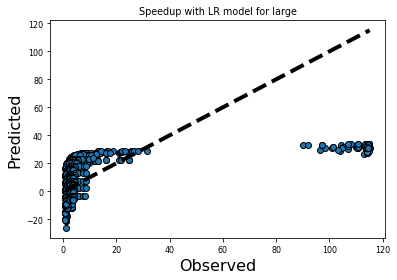

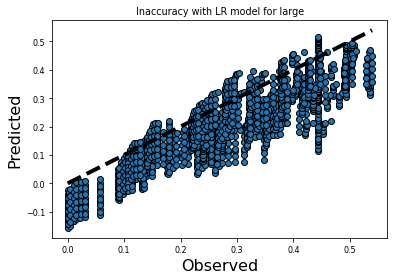

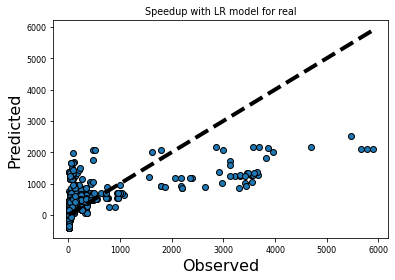

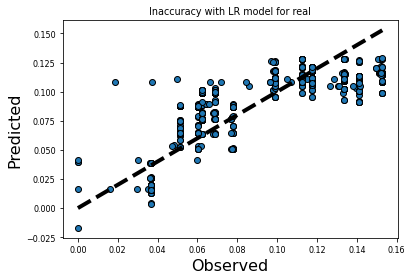

In [10]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = LinearRegression()
y_pred_lr, y_test_lr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_mo_nd, y_test_lr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
print("\n\n--- real graphs ---")
y_pred_lr_mo_nd_r, y_test_lr_mo_nd_r = _regressorAlgorithm(model, x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r)

y_pred_lr_mo_nd_s = y_pred_lr_mo_nd[:,0]
y_test_lr_mo_nd_s = y_test_lr_mo_nd[['speedup']]
scatter_plot_v2(t1_conf, y_pred_lr_mo_nd_s, y_test_lr_mo_nd_s, 'speedup_large_LR.png', 'Speedup with LR model for large')

y_pred_lr_mo_nd_e = y_pred_lr_mo_nd[:,1]
y_test_lr_mo_nd_e = y_test_lr_mo_nd[['Error']]
scatter_plot_v2(t1_conf, y_pred_lr_mo_nd_e, y_test_lr_mo_nd_e, 'inaccuracy_large_LR.png', 'Inaccuracy with LR model for large')

y_pred_lr_mo_nd_s_r = y_pred_lr_mo_nd_r[:,0]
y_test_lr_mo_nd_s_r = y_test_lr_mo_nd_r[['speedup']]
scatter_plot_v2(t1_conf, y_pred_lr_mo_nd_s_r, y_test_lr_mo_nd_s_r, 'speedup_real_LR.png', 'Speedup with LR model for real')

y_pred_lr_mo_nd_e_r = y_pred_lr_mo_nd_r[:,1]
y_test_lr_mo_nd_e_r = y_test_lr_mo_nd_r[['Error']]
scatter_plot_v2(t1_conf, y_pred_lr_mo_nd_e_r, y_test_lr_mo_nd_e_r, 'inaccuracy_real_LR.png', 'Inaccuracy with LR model for real')



KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.26321274053052346
Mean Squared Error: 0.6604741223646102
Root Mean Squared Error: 0.8126955902209696
R2 score:  0.959208380050844
Explained Variance Score:  0.9592170188015074
Mean Absolute Percentage Error:  83623374.64145216


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 1.3268340344303986
Mean Squared Error: 36.836414831497486
Root Mean Squared Error: 6.06930101671498
R2 score:  0.8260519731703369
Explained Variance Score:  0.9016331748793156
Mean Absolute Percentage Error:  17863850.37458181


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 21.014627633178442
Mean Squared Error: 7253.761651592207
Root Mean Squared Error: 85.16901814387792
R2 score:  0.934912727546443
Explained Variance S

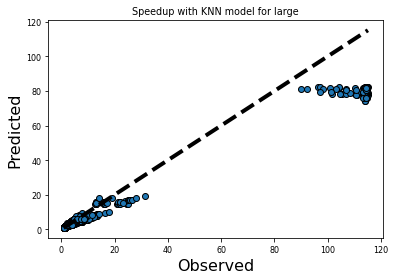

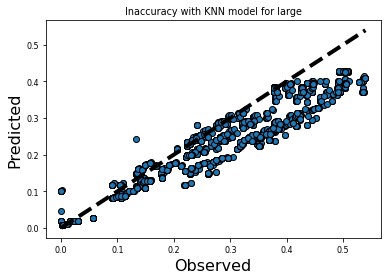

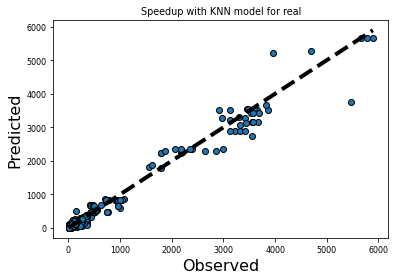

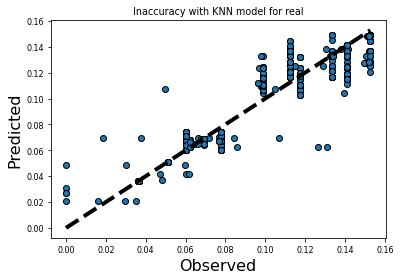

In [11]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = KNeighborsRegressor()

y_pred_knn, y_test_knn = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knn_mo_nd, y_test_knn_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
print("\n\n--- real graphs ---")
y_pred_knn_mo_nd_r, y_test_knn_mo_nd_r = _regressorAlgorithm(model, x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r)

y_pred_knn_mo_nd_s = y_pred_knn_mo_nd[:,0]
y_test_knn_mo_nd_s = y_test_knn_mo_nd[['speedup']]
scatter_plot_v2(t1_conf, y_pred_knn_mo_nd_s, y_test_knn_mo_nd_s, 'speedup_large_KNN.png', 'Speedup with KNN model for large')

y_pred_knn_mo_nd_e = y_pred_knn_mo_nd[:,1]
y_test_knn_mo_nd_e = y_test_knn_mo_nd[['Error']]
scatter_plot_v2(t1_conf, y_pred_knn_mo_nd_e, y_test_knn_mo_nd_e, 'inaccuracy_large_KNN.png', 'Inaccuracy with KNN model for large')

y_pred_knn_mo_nd_s_r = y_pred_knn_mo_nd_r[:,0]
y_test_knn_mo_nd_s_r = y_test_knn_mo_nd_r[['speedup']]
scatter_plot_v2(t1_conf, y_pred_knn_mo_nd_s_r, y_test_knn_mo_nd_s_r, 'speedup_real_KNN.png', 'Speedup with KNN model for real')

y_pred_knn_mo_nd_e_r = y_pred_knn_mo_nd_r[:,1]
y_test_knn_mo_nd_e_r = y_test_knn_mo_nd_r[['Error']]
scatter_plot_v2(t1_conf, y_pred_knn_mo_nd_e_r, y_test_knn_mo_nd_e_r, 'inaccuracy_real_KNN.png', 'Inaccuracy with KNN model for real')




RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.0841671813485215
Mean Squared Error: 0.2744354420193662
Root Mean Squared Error: 0.5238658626207344
R2 score:  0.998402282166917
Explained Variance Score:  0.99840553310198
Mean Absolute Percentage Error:  151668.6692188155


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.6307332389262601
Mean Squared Error: 7.009315348329674
Root Mean Squared Error: 2.6475111611341084
R2 score:  0.9650801476504098
Explained Variance Score:  0.9671755734694518
Mean Absolute Percentage Error:  10726.528826537657


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 18.307638089857353
Mean Squared Error: 4514.563057236518
Root Mean Squared Error: 67.19049826602358
R2 score:  0.9331502936407938
Explained Varianc

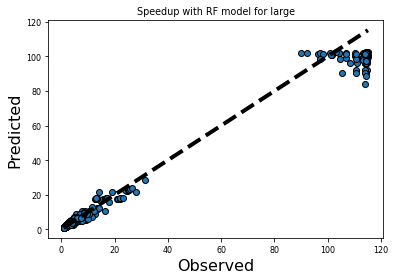

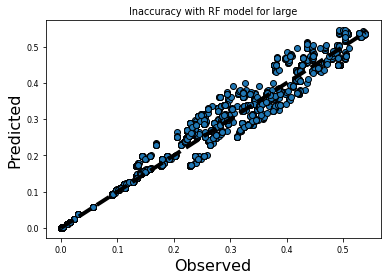

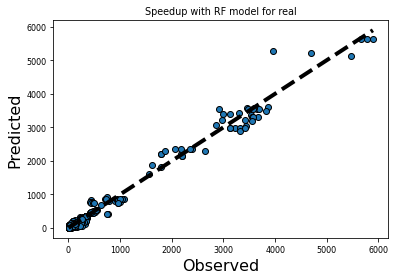

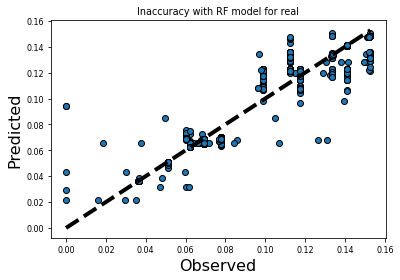

In [12]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr, y_test_rfr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_mo_nd, y_test_rfr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
print("\n\n--- real graphs ---")
y_pred_rfr_mo_nd_r, y_test_rfr_mo_nd_r = _regressorAlgorithm(model, x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r)

y_pred_rfr_mo_nd_s = y_pred_rfr_mo_nd[:,0]
y_test_rfr_mo_nd_s = y_test_rfr_mo_nd[['speedup']]
scatter_plot_v2(t1_conf, y_pred_rfr_mo_nd_s, y_test_rfr_mo_nd_s, 'speedup_large_RF.png', 'Speedup with RF model for large')

y_pred_rfr_mo_nd_e = y_pred_rfr_mo_nd[:,1]
y_test_rfr_mo_nd_e = y_test_rfr_mo_nd[['Error']]
scatter_plot_v2(t1_conf, y_pred_rfr_mo_nd_e, y_test_rfr_mo_nd_e, 'inaccuracy_large_RF.png', 'Inaccuracy with RF model for large')

y_pred_rfr_mo_nd_s_r = y_pred_rfr_mo_nd_r[:,0]
y_test_rfr_mo_nd_s_r = y_test_rfr_mo_nd_r[['speedup']]
scatter_plot_v2(t1_conf, y_pred_rfr_mo_nd_s_r, y_test_rfr_mo_nd_s_r, 'speedup_real_RF.png', 'Speedup with RF model for real')

y_pred_rfr_mo_nd_e_r = y_pred_rfr_mo_nd_r[:,1]
y_test_rfr_mo_nd_e_r = y_test_rfr_mo_nd_r[['Error']]
scatter_plot_v2(t1_conf, y_pred_rfr_mo_nd_e_r, y_test_rfr_mo_nd_e_r, 'inaccuracy_real_RF.png', 'Inaccuracy with RF model for real')



DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.10807178775441845
Mean Squared Error: 0.6702344689283672
Root Mean Squared Error: 0.8186784893524242
R2 score:  0.9967295334779919
Explained Variance Score:  0.9967311896183146
Mean Absolute Percentage Error:  198.42800231120847


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.6268549623188476
Mean Squared Error: 7.205716379477601
Root Mean Squared Error: 2.6843465460848384
R2 score:  0.96468014886759
Explained Variance Score:  0.9664058666682682
Mean Absolute Percentage Error:  0.09560795983612758


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 18.852791410796215
Mean Squared Error: 4929.282728035577
Root Mean Squared Error: 70.20885078133367
R2 score:  0.914911844368191
Explained Vari

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


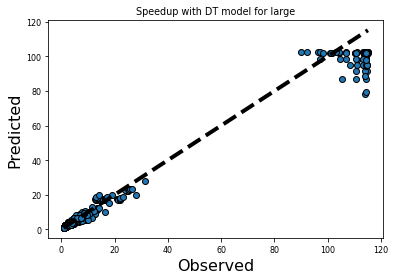

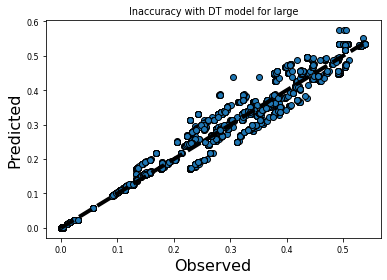

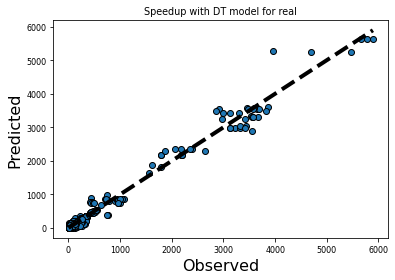

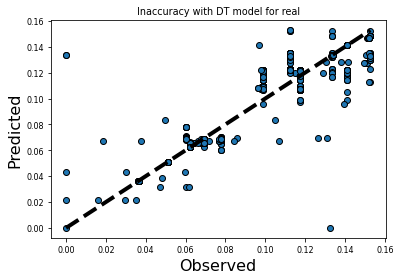

In [13]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr, y_test_dtr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_mo_nd, y_test_dtr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
print("\n\n--- real graphs ---")
y_pred_dtr_mo_nd_r, y_test_dtr_mo_nd_r = _regressorAlgorithm(model, x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r)

y_pred_dtr_mo_nd_s = y_pred_dtr_mo_nd[:,0]
y_test_dtr_mo_nd_s = y_test_dtr_mo_nd[['speedup']]
scatter_plot_v2(t1_conf, y_pred_dtr_mo_nd_s, y_test_dtr_mo_nd_s, 'speedup_large_DT.png', 'Speedup with DT model for large')

y_pred_dtr_mo_nd_e = y_pred_dtr_mo_nd[:,1]
y_test_dtr_mo_nd_e = y_test_dtr_mo_nd[['Error']]
scatter_plot_v2(t1_conf, y_pred_dtr_mo_nd_e, y_test_dtr_mo_nd_e, 'inaccuracy_large_DT.png', 'Inaccuracy with DT model for large')

y_pred_dtr_mo_nd_s_r = y_pred_dtr_mo_nd_r[:,0]
y_test_dtr_mo_nd_s_r = y_test_dtr_mo_nd_r[['speedup']]
scatter_plot_v2(t1_conf, y_pred_dtr_mo_nd_s_r, y_test_dtr_mo_nd_s_r, 'speedup_real_DT.png', 'Speedup with DT model for real')

y_pred_dtr_mo_nd_e_r = y_pred_dtr_mo_nd_r[:,1]
y_test_dtr_mo_nd_e_r = y_test_dtr_mo_nd_r[['Error']]
scatter_plot_v2(t1_conf, y_pred_dtr_mo_nd_e_r, y_test_dtr_mo_nd_e_r, 'inaccuracy_real_DT.png', 'Inaccuracy with DT model for real')




GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.27020394059382896
Mean Squared Error: 0.6569851703927477
Root Mean Squared Error: 0.8105462173082715
R2 score:  0.992378394450403
Explained Variance Score:  0.9923792052105181
Mean Absolute Percentage Error:  9160965.65820111


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.7368636497156301
Mean Squared Error: 6.616572463868659
Root Mean Squared Error: 2.572269904941676
R2 score:  0.963879247321219
Explained Variance Score:  0.9643320867872296
Mean Absolute Percentage Error:  3111404.268804377


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 46.808886362418725
Mean Squared Error: 19369.15323557271
Root Mean Squared Error: 139.17310528824422
R2 score:  0.923400216101807
Explained Varia

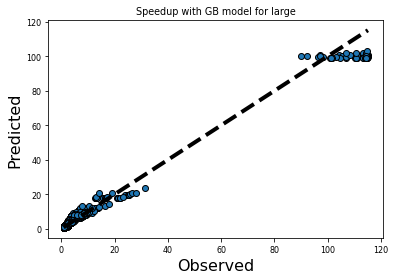

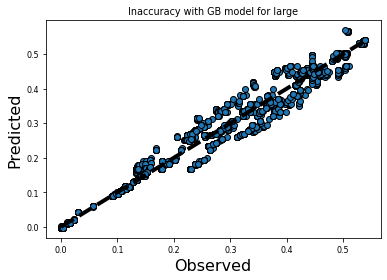

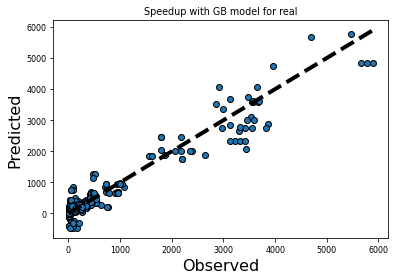

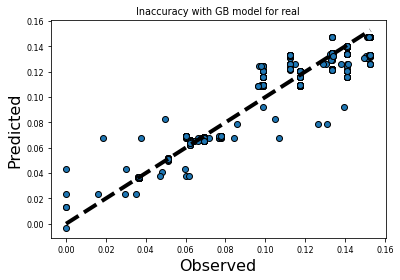

In [14]:
print("GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = MultiOutputRegressor(GradientBoostingRegressor())
y_pred_gbr, y_test_gbr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbr_mo_nd, y_test_gbr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
print("\n\n--- real graphs ---")
y_pred_gbr_mo_nd_r, y_test_gbr_mo_nd_r = _regressorAlgorithm(model, x_train_mo_r, x_test_mo_r, y_train_mo_r, y_test_mo_r)

y_pred_gbr_mo_nd_s = y_pred_gbr_mo_nd[:,0]
y_test_gbr_mo_nd_s = y_test_gbr_mo_nd[['speedup']]
scatter_plot_v2(t1_conf, y_pred_gbr_mo_nd_s, y_test_gbr_mo_nd_s, 'speedup_large_GB.png', 'Speedup with GB model for large')

y_pred_gbr_mo_nd_e = y_pred_gbr_mo_nd[:,1]
y_test_gbr_mo_nd_e = y_test_gbr_mo_nd[['Error']]
scatter_plot_v2(t1_conf, y_pred_gbr_mo_nd_e, y_test_gbr_mo_nd_e, 'inaccuracy_large_GB.png', 'Inaccuracy with GB model for large')

y_pred_gbr_mo_nd_s_r = y_pred_gbr_mo_nd_r[:,0]
y_test_gbr_mo_nd_s_r = y_test_gbr_mo_nd_r[['speedup']]
scatter_plot_v2(t1_conf, y_pred_gbr_mo_nd_s_r, y_test_gbr_mo_nd_s_r, 'speedup_real_GB.png', 'Speedup with GB model for real')

y_pred_gbr_mo_nd_e_r = y_pred_gbr_mo_nd_r[:,1]
y_test_gbr_mo_nd_e_r = y_test_gbr_mo_nd_r[['Error']]
scatter_plot_v2(t1_conf, y_pred_gbr_mo_nd_e_r, y_test_gbr_mo_nd_e_r, 'inaccuracy_real_GB.png', 'Inaccuracy with GB model for real')




# Predict Single Output - Execution

In [15]:
X_sox = df1.drop(['speedup', 'Error'],axis=1)
y_sox = df1[['speedup']]
X_sox = X_sox.values

#split the data randomly
x_train_sox, x_test_sox, y_train_sox, y_test_sox = train_test_split(X_sox, y_sox, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
x_train_sox_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_sox_nd = a[['speedup']]
x_test_sox_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_sox_nd = b[['speedup']]

t1 = x_test_sox_nd.copy()
t1_conf = conf_preprocess(t1)
t1_conf = t1.index.values - 10520

In [16]:
#real graph
X_sox_r = df1R.drop(['speedup', 'Error'],axis=1)
y_sox_r = df1R[['speedup']]
X_sox_r = X_sox_r.values

#split the data randomly
x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r = train_test_split(X_sox_r, y_sox_r, test_size=0.2, random_state=13)


LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 13.065663922906941
Mean Squared Error: 392.0484752413453
Root Mean Squared Error: 19.80021402008941
R2 score:  0.306097469017132
Explained Variance Score:  0.3061109323648773
Mean Absolute Percentage Error:  4.262165525223233


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 13.71571814783465
Mean Squared Error: 551.2927173410753
Root Mean Squared Error: 23.479623449729242
R2 score:  0.2859953298896968
Explained Variance Score:  0.2927982015030517
Mean Absolute Percentage Error:  4.379479112144262


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 392.60099058764206
Mean Squared Error: 388598.1818480457
Root Mean Squared Error: 623.376436712237
R2 score:  0.3719073182865039
Explained Variance 

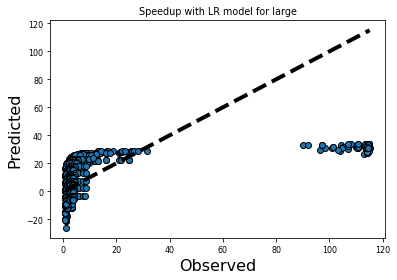

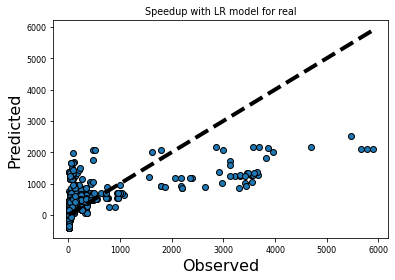

In [17]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = LinearRegression()
y_pred_lr_sox, y_test_lr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_sox_nd, y_test_lr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)
print("\n\n--- real graphs ---")
y_pred_lr_sox_nd_r, y_test_lr_sox_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

#lrsox = np.abs(y_pred_lr_sox_nd - y_test_lr_sox_nd).to_numpy()


scatter_plot_v2(t1_conf, y_pred_lr_sox_nd, y_test_lr_sox_nd, 'single_speedup_large_LR.png', 'Speedup with LR model for large')
scatter_plot_v2(t1_conf, y_pred_lr_sox_nd_r, y_test_lr_sox_nd_r, 'single_speedup_real_LR.png', 'Speedup with LR model for real')

#scatter_plot(t1_conf, y_pred_lr_sox_nd, y_test_lr_sox_nd, 'input=16777216, output=Speedup, model=Linear Regression')

KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.49433744439438154
Mean Squared Error: 1.3190715616885462
Root Mean Squared Error: 1.1485084073216645
R2 score:  0.9976653216298322
Explained Variance Score:  0.9976782158889129
Mean Absolute Percentage Error:  0.09937260419102835


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 2.5981444501047215
Mean Squared Error: 73.66800686727535
Root Mean Squared Error: 8.583006866318781
R2 score:  0.9045891605558609
Explained Variance Score:  0.9124848719957264
Mean Absolute Percentage Error:  0.10640260254794792


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 42.021260146454516
Mean Squared Error: 14507.52315627552
Root Mean Squared Error: 120.44717994322457
R2 score:  0.976551436548386
Explai

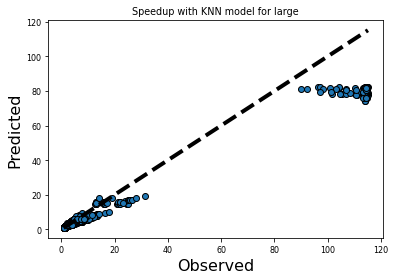

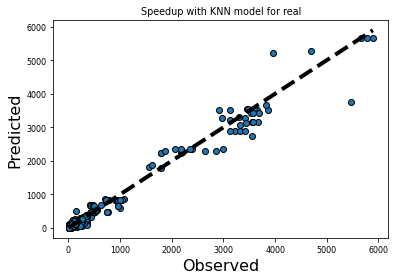

In [18]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = KNeighborsRegressor()
y_pred_knr_sox, y_test_knr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knr_sox_nd, y_test_knr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

#knrsox = np.abs(y_pred_knr_sox_nd - y_test_knr_sox_nd).to_numpy()
print("\n\n--- real graphs ---")
y_pred_knn_sox_nd_r, y_test_knn_sox_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_knr_sox_nd, y_test_knr_sox_nd, 'single_speedup_large_KNN.png', 'Speedup with KNN model for large')
scatter_plot_v2(t1_conf, y_pred_knn_sox_nd_r, y_test_knn_sox_nd_r, 'single_speedup_real_KNN.png', 'Speedup with KNN model for real')

#scatter_plot_v2(t1_conf, y_pred_knr_sox_nd, y_test_knr_sox_nd, 'Speedup only prediction, model=KNN')

#scatter_plot(t1_conf, y_pred_knr_sox_nd, y_test_knr_sox_nd, 'input=16777216, output=Speedup, model=KNeighbors Regression')

RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.16568944826366855
Mean Squared Error: 0.5547254995785043
Root Mean Squared Error: 0.7447989658817367
R2 score:  0.9990181687917004
Explained Variance Score:  0.9990190264709622
Mean Absolute Percentage Error:  0.015612532998423032


--- small graphs for training, large graphs for testing ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 1.2383843360982758
Mean Squared Error: 14.02498884639576
Root Mean Squared Error: 3.744995173080435
R2 score:  0.9818355889356397
Explained Variance Score:  0.9826372422419144
Mean Absolute Percentage Error:  0.10090463836517372


--- real graphs ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 36.62152259196241
Mean Squared Error: 9062.631836683579
Root Mean Squared Error: 95.19785626096619
R2 score:  0.9853520345704795
Explained Variance Score:  0.9853541119479833
Mean Absolute Percentage Error:  0.9519073734005777


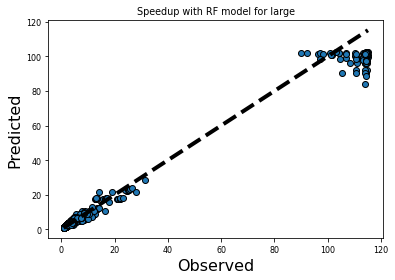

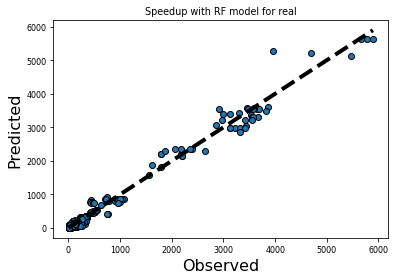

In [19]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr_sox, y_test_rfr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_sox_nd, y_test_rfr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)
print("\n\n--- real graphs ---")
y_pred_rfr_sox_nd_r, y_test_rfr_sox_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_rfr_sox_nd, y_test_rfr_sox_nd, 'single_speedup_large_RF.png', 'Speedup with RF model for large')

scatter_plot_v2(t1_conf, y_pred_rfr_sox_nd_r, y_test_rfr_sox_nd_r, 'single_speedup_real_RF.png', 'Speedup with RF model for real')

#scatter_plot(t1_conf, y_pred_rfr_sox_nd, y_test_rfr_sox_nd, 'input=16777216, output=Speedup, model=Random Forest Regression')

DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.21550895570818773
Mean Squared Error: 1.3434378338928734
Root Mean Squared Error: 1.1590676571679814
R2 score:  0.9976221947743005
Explained Variance Score:  0.9976231237182321
Mean Absolute Percentage Error:  0.018263215069441164


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 1.2357424329595192
Mean Squared Error: 14.415421728168347
Root Mean Squared Error: 3.7967646395540964
R2 score:  0.9813299212709283
Explained Variance Score:  0.9821393287574671
Mean Absolute Percentage Error:  0.10299925206460248


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 37.7073941745649
Mean Squared Error: 9858.654524434387
Root Mean Squared Error: 99.29075749753542
R2 score:  0.9840654201497006
Ex

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


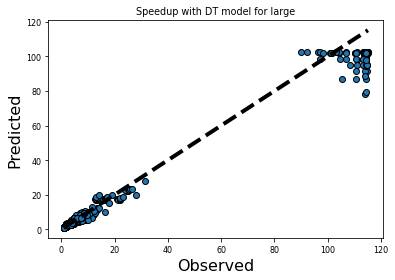

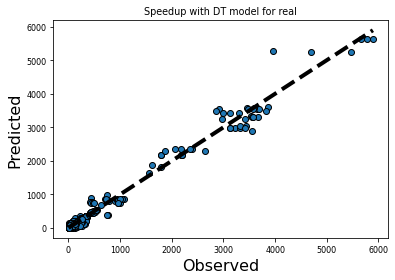

In [20]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr_sox, y_test_dtr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_sox_nd, y_test_dtr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#print(y_pred_dtr_sox_nd[:20])
#print(y_test_dtr_sox_nd.head(20))
#_regressorAlgorithm_KFold(model, X_sox, y_sox)
print("\n\n--- real graphs ---")
y_pred_dtr_sox_nd_r, y_test_dtr_sox_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_dtr_sox_nd, y_test_dtr_sox_nd, 'single_speedup_large_DT.png', 'Speedup with DT model for large')

scatter_plot_v2(t1_conf, y_pred_dtr_sox_nd_r, y_test_dtr_sox_nd_r, 'single_speedup_real_DT.png', 'Speedup with DT model for real')

#scatter_plot(t1_conf, y_pred_dtr_sox_nd, y_test_dtr_sox_nd, 'input=16777216, output=Speedup, model=Decision Tree Regression')

GRADIENT BOOSTING ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.5279578709133129
Mean Squared Error: 1.313664427537142
Root Mean Squared Error: 1.146152008913801
R2 score:  0.9976748919363376
Explained Variance Score:  0.9976750238067909
Mean Absolute Percentage Error:  0.131564791025245


--- small graphs for training, large graphs for testing ---


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 1.4492418400016422
Mean Squared Error: 13.23209236951143
Root Mean Squared Error: 3.63759431073772
R2 score:  0.982862505797774
Explained Variance Score:  0.9832432277478809
Mean Absolute Percentage Error:  0.19420395726628853


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 93.60978081164244
Mean Squared Error: 38738.30634645236
Root Mean Squared Error: 196.8204926994452
R2 score:  0.9373871318633794
Explained Variance Score:  0.9374114632956136
Mean Absolute Percentage Error:  4.682550075833595


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


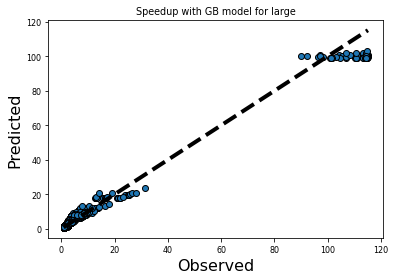

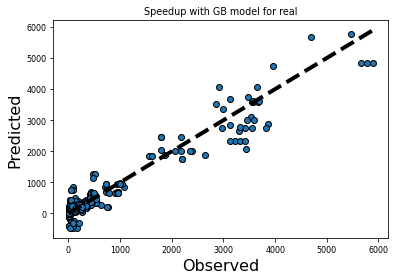

In [21]:
print("GRADIENT BOOSTING ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = GradientBoostingRegressor()
y_pred_gbc_sox, y_test_gbc_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbc_sox_nd, y_test_gbc_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)
print("\n\n--- real graphs ---")
y_pred_gbc_sox_nd_r, y_test_gbc_sox_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_gbc_sox_nd, y_test_gbc_sox_nd, 'single_speedup_large_GB.png', 'Speedup with GB model for large')

scatter_plot_v2(t1_conf, y_pred_gbc_sox_nd_r, y_test_gbc_sox_nd_r, 'single_speedup_real_GB.png', 'Speedup with GB model for real')



# Predict Single Output - Error 

In [22]:
X_soe = df1.drop(['speedup', 'Error'],axis=1)
y_soe = df1[['Error']]
X_soe = X_soe.values

#split the data randomly
x_train_soe, x_test_soe, y_train_soe, y_test_soe = train_test_split(X_soe, y_soe, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
x_train_soe_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_soe_nd = a[['Error']]
x_test_soe_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_soe_nd = b[['Error']]

In [23]:
#real graph
X_soe_r = df1R.drop(['speedup', 'Error'],axis=1)
y_soe_r = df1R[['speedup', 'Error']]
X_soe_r = X_soe_r.values

#split the data randomly
x_train_soe_r, x_test_soe_r, y_train_soe_r, y_test_soe_r = train_test_split(X_soe_r, y_soe_r, test_size=0.2, random_state=13)


LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.054240097602944536
Mean Squared Error: 0.004917566972042466
Root Mean Squared Error: 0.07012536610986403
R2 score:  0.7923410078812728
Explained Variance Score:  0.7923454781401696
Mean Absolute Percentage Error:  129125410.98512052


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.08458957503567571
Mean Squared Error: 0.010385659044226933
Root Mean Squared Error: 0.10191005369553552
R2 score:  0.4562852127765793
Explained Variance Score:  0.7720232444953736
Mean Absolute Percentage Error:  228633054.7874729


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 392.60099058764206
Mean Squared Error: 388598.1818480457
Root Mean Squared Error: 623.376436712237
R2 score:  0.3719073182865039
Explaine

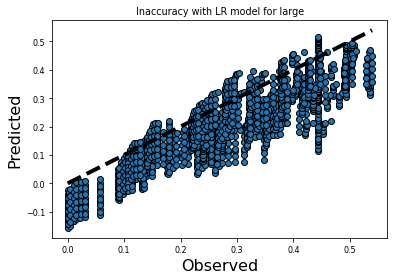

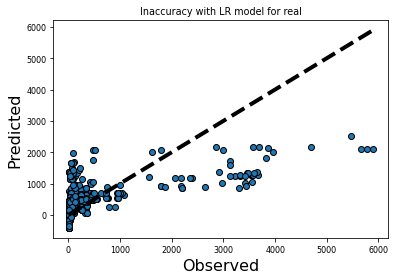

In [24]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = LinearRegression()
y_pred_lr_soe, y_test_lr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_soe_nd, y_test_lr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

print("\n\n--- real graphs ---")
y_pred_lr_soe_nd_r, y_test_lr_soe_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_lr_soe_nd, y_test_lr_soe_nd, 'single_error_large_LR.png', 'Inaccuracy with LR model for large')

scatter_plot_v2(t1_conf, y_pred_lr_soe_nd_r, y_test_lr_soe_nd_r, 'single_error_real_LR.png', 'Inaccuracy with LR model for real')


#scatter_plot_v2(t1_conf, y_pred_lr_soe_nd, y_test_lr_soe_nd, 'Inaccuracy only prediction, model=LR')

#print(type(y_pred_lr_soe_nd))

KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.032088036666666674
Mean Squared Error: 0.001876683040674032
Root Mean Squared Error: 0.043320699909789456
R2 score:  0.9207514384718556
Explained Variance Score:  0.9207558217141021
Mean Absolute Percentage Error:  167246749.1835314


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.05552361875607386
Mean Squared Error: 0.004822795719679437
Root Mean Squared Error: 0.06944635137773213
R2 score:  0.7475147857848132
Explained Variance Score:  0.8907814777629057
Mean Absolute Percentage Error:  35727700.642761275


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 42.021260146454516
Mean Squared Error: 14507.52315627552
Root Mean Squared Error: 120.44717994322457
R2 score:  0.976551436548386
Ex

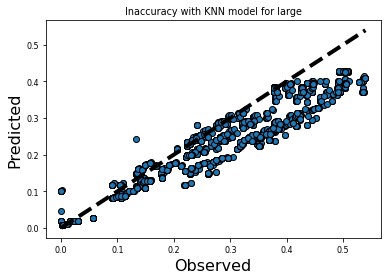

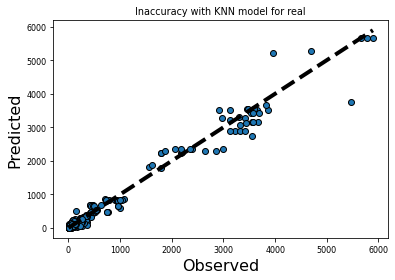

In [25]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = KNeighborsRegressor()
y_pred_knr_soe, y_test_knr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knr_soe_nd, y_test_knr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)
#print(type(y_pred_knr_soe_nd))

#scatter_plot_v2(t1_conf, y_pred_knr_soe_nd, y_test_knr_soe_nd, 'Inaccuracy only prediction, model=KNN')

print("\n\n--- real graphs ---")
y_pred_knr_soe_nd_r, y_test_knr_soe_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_knr_soe_nd, y_test_knr_soe_nd, 'single_error_large_KNN.png', 'Inaccuracy with KNN model for large')

scatter_plot_v2(t1_conf, y_pred_knr_soe_nd_r, y_test_knr_soe_nd_r, 'single_error_real_KNN.png', 'Inaccuracy with KNN model for real')



RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.0010785454416761403
Mean Squared Error: 6.107487539461101e-06
Root Mean Squared Error: 0.0024713331502371552
R2 score:  0.999742093048446
Explained Variance Score:  0.9997426315979007
Mean Absolute Percentage Error:  507.9414792561046


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.023430198129251772
Mean Squared Error: 0.0009336860999459187
Root Mean Squared Error: 0.030556277586543796
R2 score:  0.9511192369204771
Explained Variance Score:  0.952971042674543
Mean Absolute Percentage Error:  14.668323223723764


--- real graphs ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 36.62152259196241
Mean Squared Error: 9062.631836683579
Root Mean Squared Error: 95.19785626096619
R2 score:  0.9853520345704795
Explained Variance Score:  0.9853541119479833
Mean Absolute Percentage Error:  0.9519073734005777


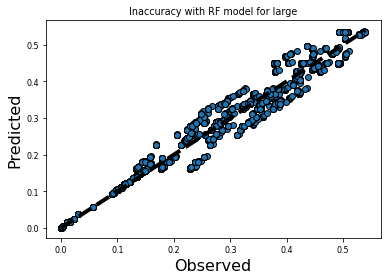

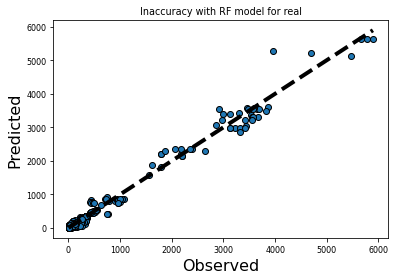

In [26]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr_soe, y_test_rfr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe.values.ravel(), y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_soe_nd, y_test_rfr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd.values.ravel(), y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

#scatter_plot_v2(t1_conf, y_pred_rfr_soe_nd, y_test_rfr_soe_nd, 'Inaccuracy only prediction, model=RF')

print("\n\n--- real graphs ---")
y_pred_rfr_soe_nd_r, y_test_rfr_soe_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_rfr_soe_nd, y_test_rfr_soe_nd, 'single_error_large_RF.png', 'Inaccuracy with RF model for large')

scatter_plot_v2(t1_conf, y_pred_rfr_soe_nd_r, y_test_rfr_soe_nd_r, 'single_error_real_RF.png', 'Inaccuracy with RF model for real')


DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.0009278924603174644
Mean Squared Error: 7.273902694246026e-06
Root Mean Squared Error: 0.0026970173700304615
R2 score:  0.9996928376754513
Explained Variance Score:  0.999692915244256
Mean Absolute Percentage Error:  396.8298238199122


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.023253654033041787
Mean Squared Error: 0.0009317752092108844
Root Mean Squared Error: 0.030524993189366717
R2 score:  0.9512192767489542
Explained Variance Score:  0.9527595797772702
Mean Absolute Percentage Error:  0.08744211113647958


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 37.7073941745649
Mean Squared Error: 9858.654524434392
Root Mean Squared Error: 99.29075749753545
R2 score:  0.984065420149

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


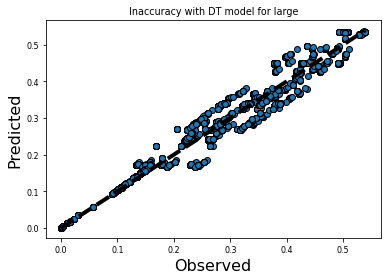

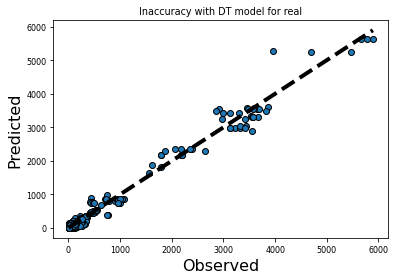

In [27]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr_soe, y_test_dtr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_soe_nd, y_test_dtr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

#scatter_plot_v2(t1_conf, y_pred_dtr_soe_nd, y_test_dtr_soe_nd, 'Inaccuracy only prediction, model=DT')

print("\n\n--- real graphs ---")
y_pred_dtr_soe_nd_r, y_test_dtr_soe_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_dtr_soe_nd, y_test_dtr_soe_nd, 'single_error_large_DT.png', 'Inaccuracy with DT model for large')

scatter_plot_v2(t1_conf, y_pred_dtr_soe_nd_r, y_test_dtr_soe_nd_r, 'single_error_real_DT.png', 'Inaccuracy with DT model for real')


GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.012450010274344997
Mean Squared Error: 0.0003059132483540664
Root Mean Squared Error: 0.017490375878009782
R2 score:  0.9870818969644685
Explained Variance Score:  0.9870833866142454
Mean Absolute Percentage Error:  18321931.184837464


--- small graphs for training, large graphs for testing ---


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.024485459429618103
Mean Squared Error: 0.0010525582258873404
Root Mean Squared Error: 0.032443153759881924
R2 score:  0.9448959888446641
Explained Variance Score:  0.9454209458265783
Mean Absolute Percentage Error:  6222808.343404921


--- real graphs ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 93.60978081164244
Mean Squared Error: 38738.30634645236
Root Mean Squared Error: 196.8204926994452
R2 score:  0.9373871318633794
Explained Variance Score:  0.9374114632956136
Mean Absolute Percentage Error:  4.6825500758335945


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


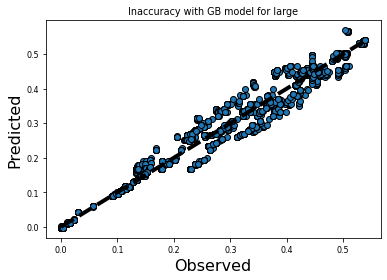

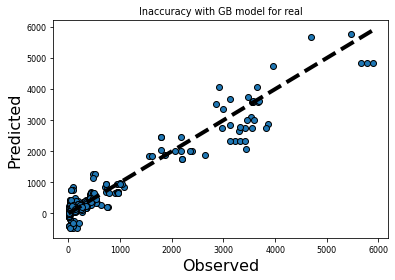

In [28]:
print("GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = GradientBoostingRegressor()
y_pred_gbr_soe, y_test_gbr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbr_soe_nd, y_test_gbr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

#scatter_plot_v2(t1_conf, y_pred_gbr_soe_nd, y_test_gbr_soe_nd, 'Inaccuracy only prediction, model=BG')

print("\n\n--- real graphs ---")
y_pred_gbr_soe_nd_r, y_test_gbr_soe_nd_r = _regressorAlgorithm(model, x_train_sox_r, x_test_sox_r, y_train_sox_r, y_test_sox_r)

scatter_plot_v2(t1_conf, y_pred_gbr_soe_nd, y_test_gbr_soe_nd, 'single_error_large_GB.png', 'Inaccuracy with GB model for large')

scatter_plot_v2(t1_conf, y_pred_gbr_soe_nd_r, y_test_gbr_soe_nd_r, 'single_error_real_GB.png', 'Inaccuracy with GB model for real')


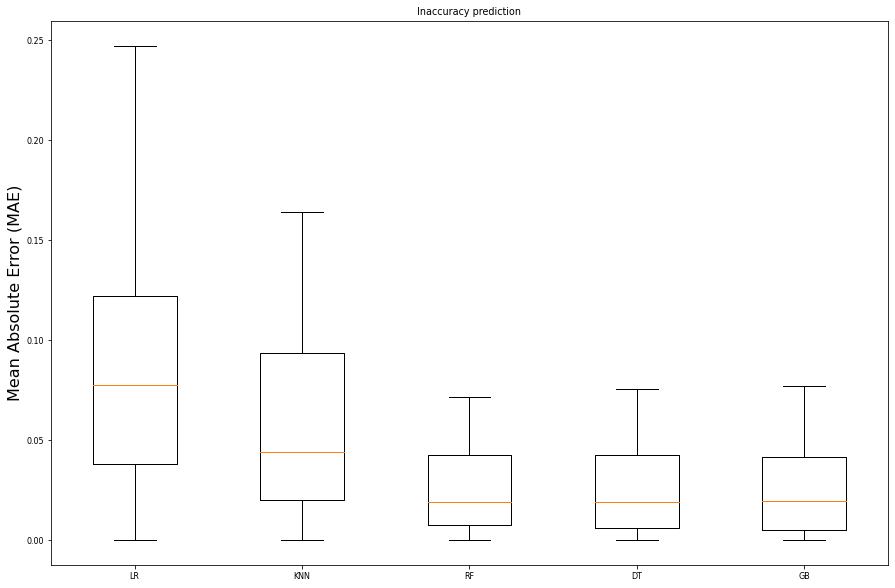

<Figure size 432x288 with 0 Axes>

In [29]:
#SINGLE OUTPUT ERROR PREDICTION 

dataError = []
dataSize = 2058 # was 4362
lrsoe = np.abs(y_pred_lr_soe_nd - y_test_lr_soe_nd).to_numpy().reshape(dataSize, )
dataError.append(lrsoe)

y_pred_knr_soe_nd = y_pred_knr_soe_nd.reshape(dataSize, 1)
knrsoe = np.abs(y_pred_knr_soe_nd - y_test_knr_soe_nd).to_numpy().reshape(dataSize, )
dataError.append(knrsoe)

y_pred_rfr_soe_nd = y_pred_rfr_soe_nd.reshape(dataSize, 1)
rfrsoe = np.abs(y_pred_rfr_soe_nd - y_test_rfr_soe_nd).to_numpy().reshape(dataSize, )
dataError.append(rfrsoe)



y_pred_dtr_soe_nd = y_pred_dtr_soe_nd.reshape(dataSize, 1)
dtrsoe = np.abs(y_pred_dtr_soe_nd - y_test_dtr_soe_nd).to_numpy().reshape(dataSize, )
dataError.append(dtrsoe)


#y_pred_mlpr_soe_nd = y_pred_mlpr_soe_nd.reshape(dataSize, 1)
#mlprsoe = np.abs(y_pred_mlpr_soe_nd - y_test_mlpr_soe_nd).to_numpy().reshape(dataSize, )
#dataError.append(mlprsoe)


#y_pred_svm_soe_nd = y_pred_svm_soe_nd.reshape(dataSize, 1)
#svmsoe = np.abs(y_pred_svm_soe_nd - y_test_svm_soe_nd).to_numpy().reshape(dataSize, )
#dataError.append(svmsoe)


y_pred_gbr_soe_nd = y_pred_gbr_soe_nd.reshape(dataSize, 1)
gbrsoe = np.abs(y_pred_gbr_soe_nd - y_test_gbr_soe_nd).to_numpy().reshape(dataSize, )
dataError.append(gbrsoe)



boxplot(dataError, 'Inaccuracy prediction')

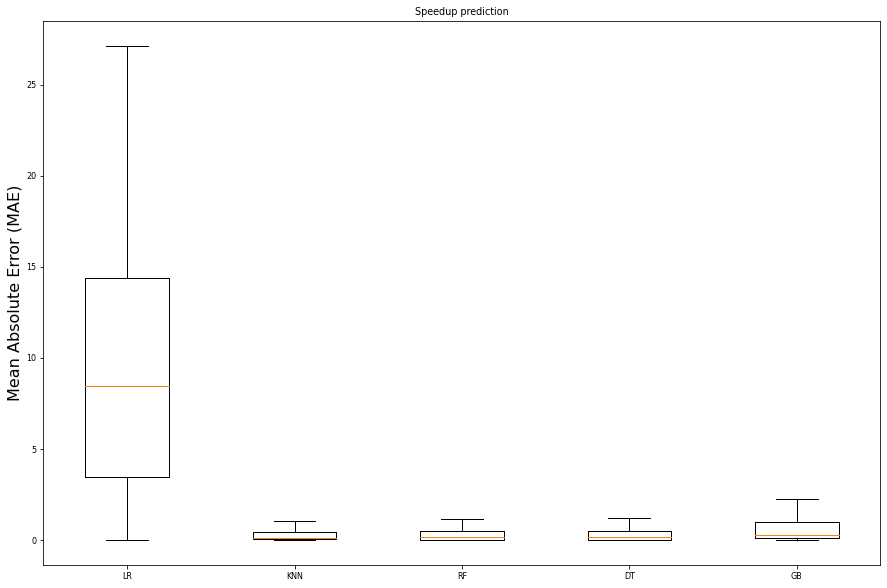

<Figure size 432x288 with 0 Axes>

In [30]:
#SINGLE OUTPUT SPEEDUP PREDICTION 
dataSize = 2058 # was 4362
dataSpeedup = []

lrsox = np.abs(y_pred_lr_sox_nd - y_test_lr_sox_nd).to_numpy().reshape(dataSize, )
dataSpeedup.append(lrsox)

y_pred_knr_sox_nd = y_pred_knr_sox_nd.reshape(dataSize, 1)
knrsox = np.abs(y_pred_knr_sox_nd - y_test_knr_sox_nd).to_numpy().reshape(dataSize, )
dataSpeedup.append(knrsox)

y_pred_rfr_sox_nd = y_pred_rfr_sox_nd.reshape(dataSize, 1)
rfrsox = np.abs(y_pred_rfr_sox_nd - y_test_rfr_sox_nd).to_numpy().reshape(dataSize, )
dataSpeedup.append(rfrsox)



y_pred_dtr_sox_nd = y_pred_dtr_sox_nd.reshape(dataSize, 1)
dtrsox = np.abs(y_pred_dtr_sox_nd - y_test_dtr_sox_nd).to_numpy().reshape(dataSize, )
dataSpeedup.append(dtrsox)


#y_pred_mlpr_sox_nd = y_pred_mlpr_sox_nd.reshape(dataSize, 1)
#mlprsox = np.abs(y_pred_mlpr_sox_nd - y_test_mlpr_sox_nd).to_numpy().reshape(dataSize, )
#dataSpeedup.append(mlprsox)


#y_pred_svm_sox_nd = y_pred_svm_sox_nd.reshape(dataSize, 1)
#svmsox = np.abs(y_pred_svm_sox_nd - y_test_svm_sox_nd).to_numpy().reshape(dataSize, )
#dataSpeedup.append(svmsox)


y_pred_gbc_sox_nd = y_pred_gbc_sox_nd.reshape(dataSize, 1)
gbcsox = np.abs(y_pred_gbc_sox_nd - y_test_gbc_sox_nd).to_numpy().reshape(dataSize, )
dataSpeedup.append(gbcsox)



boxplot(dataSpeedup, 'Speedup prediction')